# Creates an MS-COCO style dataset for powerpoint

In [292]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</s}tyle>"))

In [365]:
# win32 com
#http://www.s-anand.net/blog/automating-powerpoint-with-python/
#https://docs.microsoft.com/en-us/office/vba/api/powerpoint.fillformat.visible
import win32com.client
import os
import random
import numpy as np
import PIL
from tqdm import tqdm
import random 
import lib
from natsort import natsorted

In [442]:
Application = win32com.client.Dispatch('PowerPoint.Application')
slide_height, slide_width = 540, 960
IMAGE_RES_DIVISOR = 1

In [412]:
part_x, part_y = (slide_height/IMAGE_RES_DIVISOR)/32, (slide_width/IMAGE_RES_DIVISOR)/32 
print(part_x*part_y, part_x, part_y)

379.6875 16.875 22.5


In [413]:
from importlib import reload
reload(lib)
reload(lib.ppt_interface)
from lib.ppt_interface import PPT_shapes, add_shape, add_line, add_title, add_textBox, convert_line_xyhw_to_points
shape_manager = PPT_shapes()

In [414]:
# Alright, lets generate some training data!

choices = [
             'TextBox',
             'StraightConnector',
             'Rectangle',
             'LeftArrow',
             'Chevron',
             'Oval',
             'Donut',
             'IsoscelesTriangle',
        ]


def make_training_data_slide():
    slide = Presentation.Slides.Add(1, 11)
    
    # Put some text in the title
    slide.shapes.Title.TextFrame.TextRange.Text = "Title"
    
    num_shapes = np.random.randint(5,10) 
    
    for s in range(0,num_shapes):
        choice = np.random.choice(choices)
        
        info = shape_manager.shapes[choice]
        if info[1] == 'line':
            # either horizontal or vertical only
            if np.random.uniform() < 0.5: # vertical
                x1, y1 = np.random.uniform(0.2,0.9), np.random.uniform(0.2,0.5)
                x2 = x1
                y2 = y1 + min(np.random.uniform(0.3,0.6), 1-y1)
            else: # vertical
                x1, y1 = np.random.uniform(0.2,0.5), np.random.uniform(0.2,0.9)
                y2 = y1
                x2 = x1 + min(np.random.uniform(0.3,0.6), 1-x1)
            
            x1,x2, y1,y2 = x1*slide_width, x2*slide_width, y1*slide_height, y2*slide_height
            add_line(slide, x1,y1,x2,y2)
        else:
            x = np.random.uniform(0.2,0.8)
            y = np.random.uniform(0.2,0.7)
            h = min(np.random.uniform(0.1,0.3), 1-y)
            w = min(np.random.uniform(0.1,0.3), 1-x) # don't want it bigger than the frame

            x,w, y,h = x*slide_width, w*slide_width, y*slide_height, h*slide_height

            rgb = np.zeros(3) # default 0
            border = 0 #default 0 
            fill = 1# np.random.randint(2)
            if fill == 1:
                col = np.random.randint(3)
                rgb[col] = 1 # literally only do r, g or b at the moment. This isn't a color accuracy test
            else:
                border = 1 # if not filled, then do a border
            text = 0# np.random.randint(2)

            ####################################
            if info[1] == 'textBox':
                add_textBox(slide, x,y,h,w)
            if info[1] == 'shape':
                add_shape(slide, info[0], x,y,h,w, rgb, border, fill,text)
        
    return slide

In [429]:
# Presentation = Application.Presentations.Add()
# slide = Presentation.Slides.Add(1, 11)
# add_shape(slide, 1, 0,520,20,20, [0,0,0])

In [428]:
#Presentation = Application.Presentations.Open(os.getcwd()+ '\\Presentation.pptx') # need full path with win22com
# Create a new ppt deck


# Make the deck of examples

In [341]:
def try_dir(path):
    try:
        os.makedirs(path)
    except Exception as e:
        print(e)
        pass


In [465]:
train_path =  os.getcwd()+ '\\data\\rgb_ppt\\train'
val_path =  os.getcwd()+ '\\data\\rgb_ppt\\val'
path = val_path
deck_path = path + '/decks/'
try_dir(deck_path)


In [466]:
existing_presos = len(os.listdir(path+'/decks/'))
N_PRESOS = existing_presos+1
for p in tqdm(range(existing_presos, N_PRESOS)):
    Presentation = Application.Presentations.Add()
    for i in range(0,40):
        make_training_data_slide() 
    Presentation.saveAs(path+f'/decks/{p}')
    Presentation.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.72s/it]


# Save images to disk

In [ ]:
images = []
annotations = []

counter = 0
anno_counter = 0
for p in natsorted(os.listdir(path+'/decks/')):
    if '~' in p: # don't want the intermediate checkpoints
        continue
    Presentation = Application.Presentations.Open(f'{path}\\decks\\' + p)
    # Make a dir for the images from tha
    for i,slide in tqdm(enumerate(Presentation.Slides)):
        readout = read_slide(slide)
        slide.Export(path+f"/{counter}.jpg", 'JPG', slide_width, slide_height)
        images.append({
            "id": counter,
            "file_name": f"{counter}.jpg",
            "width": slide_width,
            "height": slide_height,
            "date_captured":  "2021-06-20 01:55:23.687250",
            "license": 1,
            "coco_url": "",
            "flickr_url": "",
        })
        for anno in readout:
            annotations.append({
                "id": anno_counter,
                "image_id": counter,
                "category_id": anno['class'],
                "iscrowd": 0,
                "area": anno['height']*anno['width'],
                "bbox": [anno['left'], anno['top'], anno['width'], anno['height']],
                "segmentation": [],
                
            })
            anno_counter += 1
        
        counter += 1
        
    Presentation.close()

0it [00:00, ?it/s]

In [461]:
import json
data =  {
    "info":           {
                      "description": "PPTAI",
                      "url": "sholtodouglas.github.io",
                      "version": "0.1.0",
                      "year": 2021,
                      "contributor": "sholtodouglas",
                      "date_created": "2021-06-20 01:55:39.314230"
                      },
    "licenses": [
                  {
                      "id": 1,
                      "name": "Mine",
                      "url": "Mine"
                  }
                ],
    "categories" : [],
    "images": images,
    "annotations": annotations,
}

for name, ID in shape_manager.classIDs.items():
    data['categories'].append({'id': ID, 'name':name, 'supercategory':"N/A"})
json_object = json.dumps(data, indent = 4)  
print(json_object) 

{
    "info": {
        "description": "PPTAI",
        "url": "sholtodouglas.github.io",
        "version": "0.1.0",
        "year": 2021,
        "contributor": "sholtodouglas",
        "date_created": "2021-06-20 01:55:39.314230"
    },
    "licenses": [
        {
            "id": 1,
            "name": "Mine",
            "url": "Mine"
        }
    ],
    "categories": [
        {
            "id": 0,
            "name": "Title",
            "supercategory": "N/A"
        },
        {
            "id": 1,
            "name": "TextBox",
            "supercategory": "N/A"
        },
        {
            "id": 2,
            "name": "StraightConnector",
            "supercategory": "N/A"
        },
        {
            "id": 3,
            "name": "Rectangle",
            "supercategory": "N/A"
        },
        {
            "id": 4,
            "name": "LeftArrow",
            "supercategory": "N/A"
        },
        {
            "id": 5,
            "name": "Chevron",
      

In [464]:
if "train" in path:
    with open(f'{path}//custom_train.json', 'w') as f:
        json.dump(data, f)
else:
    with open(f'{path}//custom_val.json', 'w') as f:
        json.dump(data, f)

In [447]:
# gsutil -m cp data/test/tf_records/*.tfrecords gs://artificial_graphics/data/test/tf_records

In [448]:
DATA_BASE = 'data/rgb_ppt/'

In [449]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_val.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["target"][0] # remove batch dimension

        return pixel_values, target

In [450]:
# Based on the class defined above, we create training and validation datasets.
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder=f'{DATA_BASE}/train', feature_extractor=feature_extractor)
#val_dataset = CocoDetection(img_folder=f'{DATA_BASE}/val', feature_extractor=feature_extractor, train=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [451]:
print("Number of training examples:", len(train_dataset))
# print("Number of validation examples:", len(val_dataset))

Number of training examples: 10


Image n°8


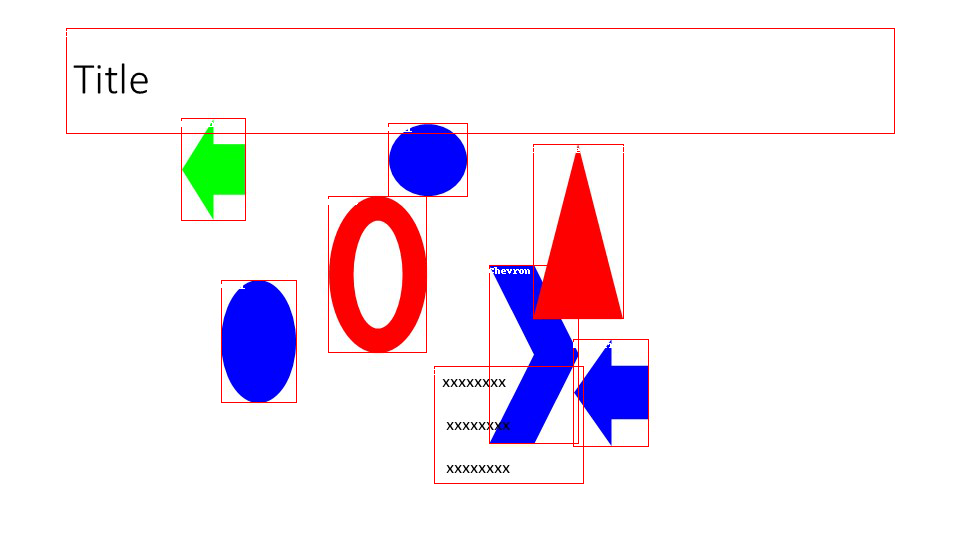

In [458]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{DATA_BASE}/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image